In [ ]:
!pip install mat4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mat4py import loadmat
import os
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

In [ ]:
import coco_eval
import coco_utils
import engine
import pascal_dataset
import transforms
import utils

In [ ]:
print(torch.cuda.get_device_properties(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


آماده کردن دیتاست برای انجام مسئله

In [ ]:
from pascal_dataset import PASCALDataset
dataset_train = PASCALDataset('/content/drive/My Drive/PASCAL/train/')
dataset_test = PASCALDataset('/content/drive/My Drive/PASCAL/test/')
dataset_val = PASCALDataset('/content/drive/My Drive/PASCAL/val/')

In [ ]:
dataset_val.__getitem__(1)

(tensor([[[0.4863, 0.4902, 0.4863,  ..., 0.2118, 0.1098, 0.0196],
          [0.4431, 0.4667, 0.4784,  ..., 0.3529, 0.2941, 0.1804],
          [0.4627, 0.4627, 0.4784,  ..., 0.4000, 0.3843, 0.3176],
          ...,
          [0.3569, 0.3569, 0.3451,  ..., 0.3490, 0.3569, 0.3608],
          [0.3686, 0.3569, 0.3608,  ..., 0.3412, 0.3490, 0.3529],
          [0.3647, 0.3451, 0.3490,  ..., 0.3098, 0.3137, 0.3137]],
 
         [[0.5255, 0.5176, 0.5137,  ..., 0.3216, 0.2314, 0.1412],
          [0.4471, 0.4706, 0.4824,  ..., 0.4549, 0.4039, 0.2902],
          [0.4588, 0.4588, 0.4745,  ..., 0.4824, 0.4745, 0.4118],
          ...,
          [0.3451, 0.3608, 0.3647,  ..., 0.3804, 0.3882, 0.4000],
          [0.3569, 0.3529, 0.3725,  ..., 0.3725, 0.3882, 0.3922],
          [0.3412, 0.3412, 0.3608,  ..., 0.3490, 0.3529, 0.3529]],
 
         [[0.4941, 0.4902, 0.4824,  ..., 0.2667, 0.1686, 0.0784],
          [0.4275, 0.4471, 0.4588,  ..., 0.4039, 0.3490, 0.2314],
          [0.4392, 0.4392, 0.4549,  ...,

In [ ]:
def new_concat(batch):
  return tuple(zip(*batch))


In [ ]:
#dataloder
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=1,shuffle=True,collate_fn=new_concat)
test_loader = torch.utils.data.DataLoader(dataset_test,batch_size=1,shuffle=False,collate_fn=new_concat)
val_loader = torch.utils.data.DataLoader(dataset_val,batch_size=1,shuffle=True,collate_fn=new_concat)

In [ ]:
# get one batch
imgs,targets = next(iter(train_loader))

In [ ]:
imgs

(tensor([[[0.9647, 0.9608, 0.9569,  ..., 1.0000, 1.0000, 1.0000],
          [0.9647, 0.9647, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
          [0.9647, 0.9647, 0.9647,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.4784, 0.4627, 0.4863,  ..., 0.6235, 0.5686, 0.5882],
          [0.5412, 0.5608, 0.5843,  ..., 0.8039, 0.7569, 0.8392],
          [0.5412, 0.5608, 0.5843,  ..., 0.6784, 0.6824, 0.6196]],
 
         [[0.9961, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.4824, 0.4667, 0.4902,  ..., 0.6275, 0.5725, 0.5882],
          [0.5451, 0.5647, 0.5922,  ..., 0.8039, 0.7569, 0.8392],
          [0.5451, 0.5647, 0.5922,  ..., 0.6784, 0.6824, 0.6196]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [ ]:
targets

({'boxes': tensor([[280., 201., 397., 297.],
          [108., 230., 189., 271.],
          [129., 208., 165., 262.],
          [329., 171., 381., 271.],
          [277., 201., 301., 272.]]),
  'labels': tensor([4, 4, 1, 1, 1]),
  'image_id': tensor([229]),
  'area': tensor([11232.,  3321.,  1944.,  5200.,  1704.]),
  'iscrowd': tensor([0, 0, 0, 0, 0])},)

In [ ]:
# define model:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,6)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 192MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=6, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=24, bias=True)
  )
)

## Training



In [ ]:
##-----------------------------------------------------------------------------
from engine import train_one_epoch
from engine import evaluate
num_epochs = 5
print_freq=100

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.9)

for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq, scaler=None)
    print('epoch [{}]:  \t lr: {}  \t loss: {}  '.format(epoch, lr_scheduler.get_last_lr(), loss))
    lr_scheduler.step()

    evaluate(model, test_loader, device)

Epoch: [0]  [   0/1002]  eta: 1:17:25  lr: 0.000010  loss: 1.9621 (1.9621)  loss_classifier: 1.8874 (1.8874)  loss_box_reg: 0.0628 (0.0628)  loss_objectness: 0.0097 (0.0097)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 4.6365  data: 2.1479  max mem: 1163
Epoch: [0]  [ 100/1002]  eta: 0:29:00  lr: 0.000509  loss: 0.3051 (0.8527)  loss_classifier: 0.1300 (0.5306)  loss_box_reg: 0.1786 (0.2964)  loss_objectness: 0.0052 (0.0121)  loss_rpn_box_reg: 0.0040 (0.0136)  time: 1.6539  data: 1.4084  max mem: 1566
Epoch: [0]  [ 200/1002]  eta: 0:23:44  lr: 0.001009  loss: 0.2949 (0.6364)  loss_classifier: 0.1042 (0.3378)  loss_box_reg: 0.1593 (0.2720)  loss_objectness: 0.0036 (0.0108)  loss_rpn_box_reg: 0.0111 (0.0159)  time: 1.5986  data: 1.3506  max mem: 1566
Epoch: [0]  [ 300/1002]  eta: 0:20:05  lr: 0.001508  loss: 0.2988 (0.5484)  loss_classifier: 0.0845 (0.2643)  loss_box_reg: 0.1683 (0.2552)  loss_objectness: 0.0018 (0.0129)  loss_rpn_box_reg: 0.0129 (0.0160)  time: 1.6026  data: 1.3552  max me

# Testing our Model

In [ ]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
from torchvision import transforms as torchtrans
import matplotlib.patches as patches

def plot_img_bbox_t(img, target):
    final_list = []
    # plot the image and bboxes
    #
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    reverse_label_dict = {1: "Person", 2: "bicycle" , 3:"car" , 4:"motor" , 5:"Airplane"}
    reverse_labelcolor_dict = {1: "r", 2: "m", 3:"b",4:"y" , 5:"g"}
    unique_vals, counts = torch.unique(target['labels'], return_counts=True)
    num_label = dict(zip(unique_vals.tolist(), counts.tolist()))
    #print(num_label)
    a.imshow(img)
    for box, label in  zip(target['boxes'], target['labels']):
        rect = patches.Rectangle((box[0], box[1]),
                                  (box[2] - box[0]),
                                  (box[3] - box[1]),
                                 linewidth = 2,
                                 fill=False,
                                 edgecolor=reverse_labelcolor_dict[label.item()])

        # Draw the bounding box on top of the image

        a.add_patch(rect)

    for i  in num_label:
      final_list.append(mpatches.Patch(color=reverse_labelcolor_dict[i], label="{} : {} ".format(reverse_label_dict[i],num_label[i])) )

    plt.legend(handles=final_list, loc='best')
    plt.title("EXPECTED OUTPUT")
    plt.show()



In [ ]:
import numpy as np

def plot_img_bbox_p(img, prediction, threshold):
    final_list = []
    # plot the image and bboxes
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    reverse_label_dict = {1: "Person", 2: "bicycle" , 3:"car" , 4:"motor" , 5:"Airplane"}
    reverse_labelcolor_dict = {1: "r", 2: "m", 3:"b",4:"y" , 5:"g"}
    #unique_vals, counts = torch.unique(prediction['labels'], return_counts=True)
    #num_label = dict(zip(unique_vals.tolist(), counts.tolist()))
    #print(num_label)
    a.imshow(img)
    b =prediction['scores']>threshold
    bb= b.cpu().numpy()

    lbl = prediction['labels'].cpu().numpy()
    lbl = lbl[bb]

    lbb = prediction['boxes'].cpu().numpy()
    lbb = lbb[bb]

    #print(lbl)
    num_label ={value: (lbl == value).sum() for value in np.unique(lbl)}

    for box, label in  zip(lbb, lbl):
        #print("label",label)
        rect = patches.Rectangle((box[0], box[1]),
                                  (box[2] - box[0]),
                                  (box[3] - box[1]),
                                 linewidth = 2,
                                 fill=False,
                                 edgecolor=reverse_labelcolor_dict[label.item()])

        # Draw the bounding box on top of the image

        a.add_patch(rect)

    for i  in num_label:
      final_list.append(mpatches.Patch(color=reverse_labelcolor_dict[i], label="{} : {} ".format(reverse_label_dict[i],num_label[i])) )

    plt.legend(handles=final_list, loc='best')
    plt.title("MODEL OUTPUT")
    plt.show()

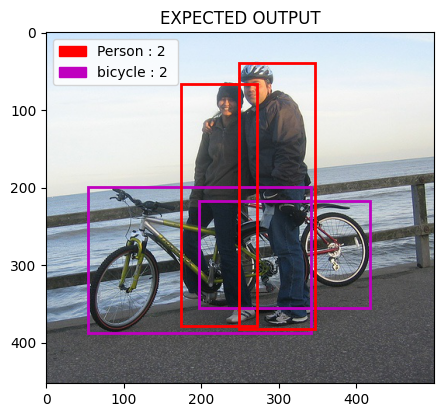

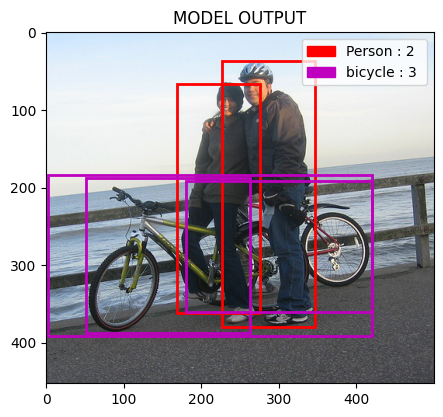

In [ ]:
img0, target0 = dataset_test[0]
model.eval()
with torch.no_grad():
    prediction0 = model([img0.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img0), target0)
plot_img_bbox_p(torch_to_pil(img0), prediction0,0.6)

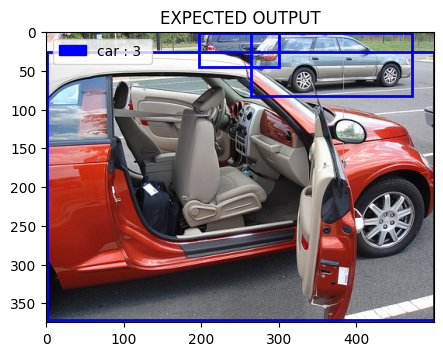

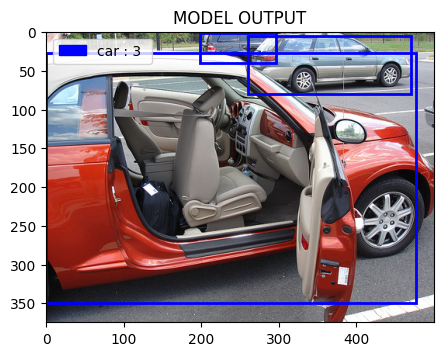

In [ ]:
img1, target1 = dataset_test[1]
model.eval()
with torch.no_grad():
    prediction1 = model([img1.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img1), target1)
plot_img_bbox_p(torch_to_pil(img1), prediction1,0.6)

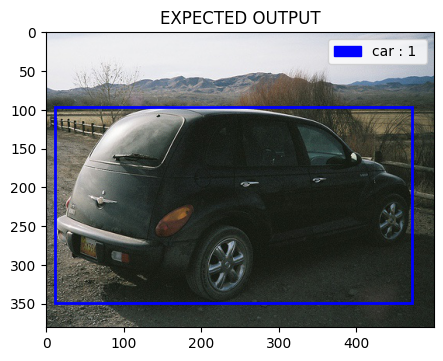

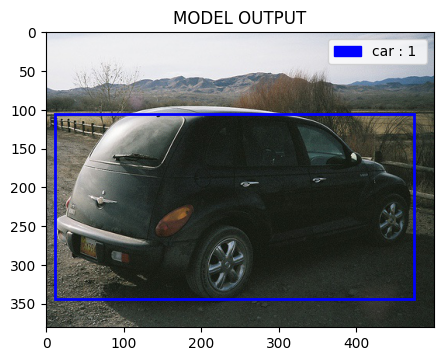

In [ ]:
img2, target2 = dataset_test[2]
model.eval()
with torch.no_grad():
    prediction2 = model([img2.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img2), target2)
plot_img_bbox_p(torch_to_pil(img2), prediction2,0.6)

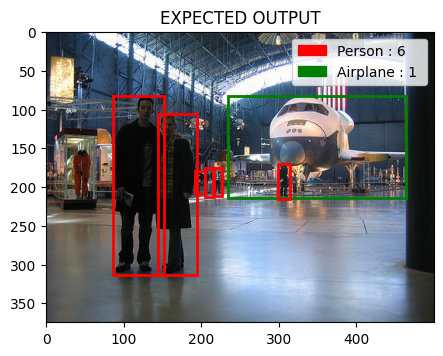

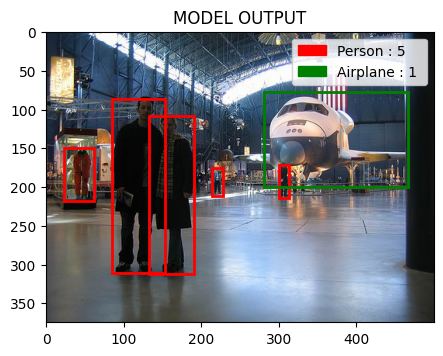

In [ ]:
img2, target2 = dataset_test[28]
model.eval()
with torch.no_grad():
    prediction2 = model([img2.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img2), target2)
plot_img_bbox_p(torch_to_pil(img2), prediction2,0.6)

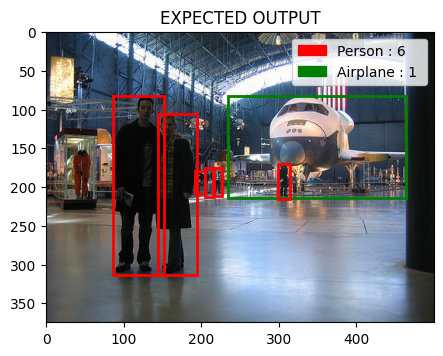

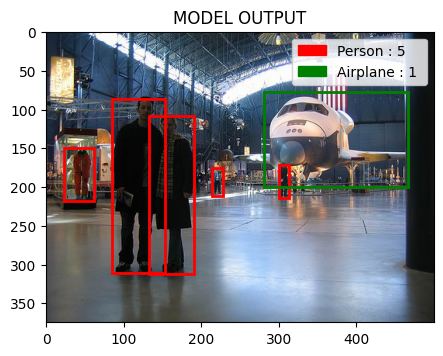

In [ ]:
img2, target2 = dataset_test[28]
model.eval()
with torch.no_grad():
    prediction2 = model([img2.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img2), target2)
plot_img_bbox_p(torch_to_pil(img2), prediction2,0.5)

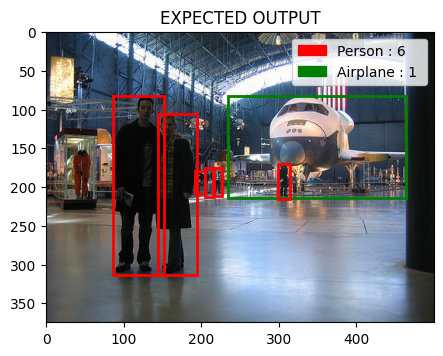

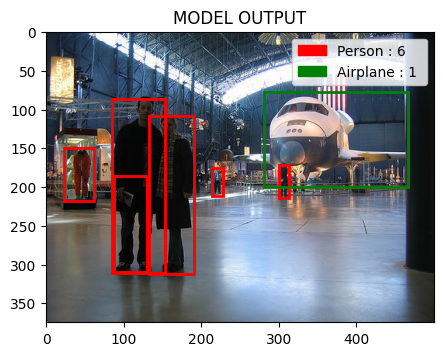

In [ ]:
img2, target2 = dataset_test[28]
model.eval()
with torch.no_grad():
    prediction2 = model([img2.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img2), target2)
plot_img_bbox_p(torch_to_pil(img2), prediction2,0.4)

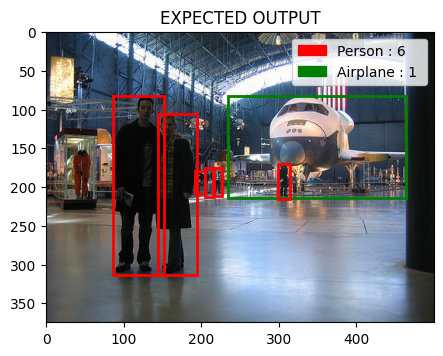

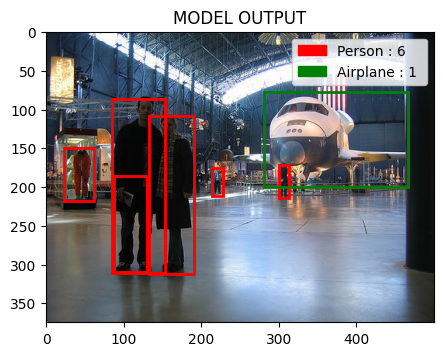

In [ ]:
img2, target2 = dataset_test[28]
model.eval()
with torch.no_grad():
    prediction2 = model([img2.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img2), target2)
plot_img_bbox_p(torch_to_pil(img2), prediction2,0.3)

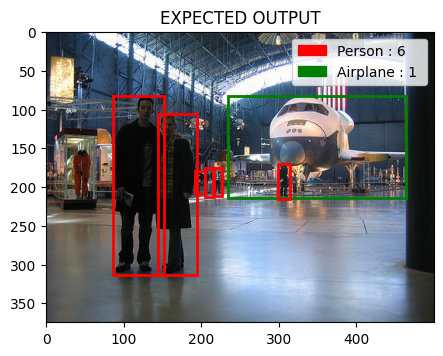

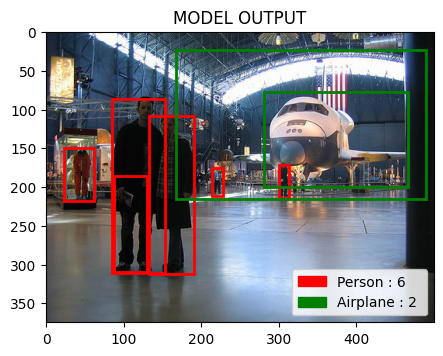

In [ ]:
img2, target2 = dataset_test[28]
model.eval()
with torch.no_grad():
    prediction2 = model([img2.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img2), target2)
plot_img_bbox_p(torch_to_pil(img2), prediction2,0.2)

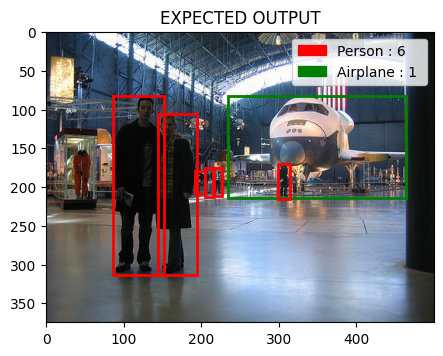

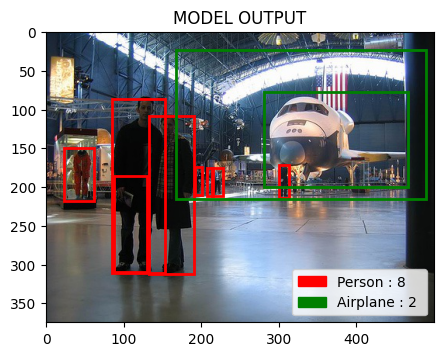

In [ ]:
img2, target2 = dataset_test[28]
model.eval()
with torch.no_grad():
    prediction2 = model([img2.to(device)])[0]

plot_img_bbox_t(torch_to_pil(img2), target2)
plot_img_bbox_p(torch_to_pil(img2), prediction2,0.1)

نمایش نتایج آموزش بدون محدودیتی روی حدآستانه:

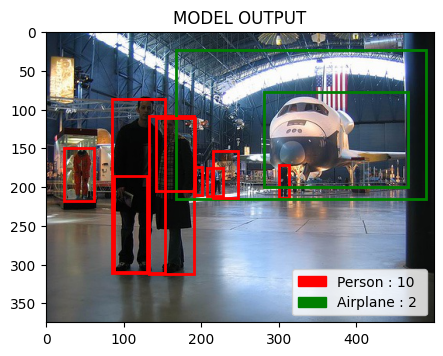

In [ ]:
plot_img_bbox_p(torch_to_pil(img2), prediction2,0)

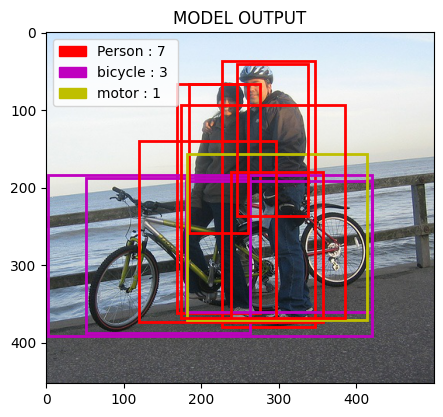

In [ ]:
plot_img_bbox_p(torch_to_pil(img0), prediction0,0)

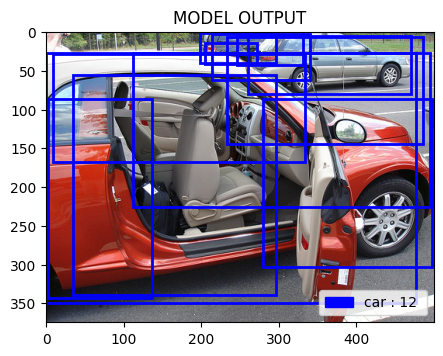

In [ ]:
plot_img_bbox_p(torch_to_pil(img1), prediction1,0)

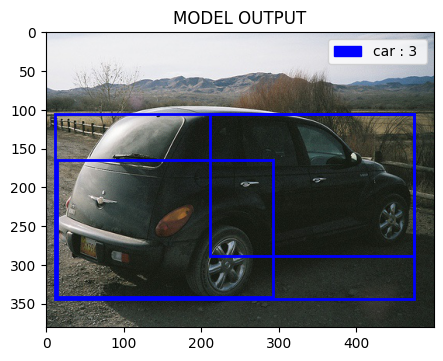

In [ ]:
plot_img_bbox_p(torch_to_pil(img2), prediction2,0)

##--------------------------------------------------------------------------------------------------------------------------------------------------------------